## Part a) Shortest Times Calculation

In [2]:
import pandas as pd
import numpy as np

# Change the path below
path_to_Gurobi = "/opt/anaconda3/bin/gurobi_cl"

In [4]:
# read data
df = pd.read_csv("Supermarket_Sweep.csv")

# start node's coords
start_x, start_y = df.loc[0, ["X Position", "Y Position"]]

# retrieve just items
items_df = df.iloc[1:].reset_index(drop=True)
coords = items_df[["X Position", "Y Position"]].to_numpy()
n_items = len(items_df) # 56

n_nodes = n_items + 1 # 57
d = np.zeros((n_nodes, n_nodes), dtype=float)

In [6]:
vl = 110.0 # vertical length
speed = 10.0 # ft per second

# calculate shortest walking distance between two points (ft)
def aisle_dist(x1, y1, x2, y2):
    # same location/coords
    if x1 == x2 and y1 == y2:
        return 0.0
        
    # same aisle -> vertical dist only
    if x1 == x2:
        return abs(y1 - y2)

    # different aisles -> shorter of bottom vs. top route
    x_diff = abs(x1 - x2)
    bottom = y1 + x_diff + y2
    top = (vl - y1) + x_diff + (vl - y2)
    
    return min(bottom, top)

In [8]:
# item -> item times
for i in range(n_items):
    x_i, y_i = coords[i]
    for j in range(n_items):
        x_j, y_j = coords[j]
        dist_ij = aisle_dist(x_i, y_i, x_j, y_j)
        d[i+1, j+1] = dist_ij / speed

# start -> item times
for i in range(n_items):
    x_i, y_i = coords[i]
    time_si = aisle_dist(start_x, start_y, x_i, y_i) / speed
    d[0, i+1] = time_si
    d[i+1, 0] = time_si

In [10]:
labels = ["Start"] + items_df["Item "].tolist()
d_df = pd.DataFrame(d, index=labels, columns=labels)

d_df.to_csv("shortest_times.csv", index=True)
print(d_df.shape) # 57 x 57

(57, 57)


## Part c) Optimization Problem

In [13]:
import pandas as pd
from pulp import *

In [15]:
# load data
df = pd.read_csv("Supermarket_Sweep.csv")

start_row = df.iloc[0]
items_df = df.iloc[1:].reset_index(drop=True)

n_items = len(items_df)

In [17]:
# parameters
I = list(range(1, n_items + 1))
S = [1, 2]
v = {i: float(items_df.loc[i-1, "Price"]) for i in I}
T = 60.0
M = T

d_df = pd.read_csv("shortest_times.csv", index_col=0)
d_temp = d_df.to_numpy()

n_nodes_without_end = d_temp.shape[0] # 57
assert n_nodes_without_end == n_items + 1, "size mismatch"

start_idx = 0
end_idx = n_nodes_without_end
n_nodes = n_nodes_without_end + 1

N = list(range(0, n_nodes))

d = {}

# base times from csv
for i in range(n_nodes_without_end):
    for j in range(n_nodes_without_end):
        d[(i, j)] = float(d_temp[i, j])

# adding item -> end times
for i in I:
    d[(i, end_idx)] = d[(i, start_idx)]

d[(start_idx, end_idx)] = 0.0
d[(end_idx, start_idx)] = 0.0

In [19]:
def solve_supermarket_sweep(I, S, v, T, M, d):
    """
    Solves the supermarket sweep problem for the given parameters and returns the optimal value
    """
    # build model
    prob = LpProblem("Supermarket_Sweep", LpMaximize)
    
    # decision variables
    # x_ijs
    x = LpVariable.dicts(
        "x",
        ((i, j, s) for i in N for j in N for s in S),
        lowBound=0,
        upBound=1,
        cat=LpBinary
    )
    
    # y_js
    y = LpVariable.dicts(
        "y",
        ((j, s) for j in N for s in S),
        lowBound=0,
        cat="Continuous"
    )
    
    # t_ijs
    t = LpVariable.dicts(
        "t",
        ((i, j, s) for i in N for j in N for s in S),
        lowBound=0,
        cat="Continuous"
    )
    
    # g_is
    g = LpVariable.dicts(
        "g",
        ((i, s) for i in I for s in S),
        lowBound=0,
        upBound=1,
        cat=LpBinary
    )

    # objective function
    prob += lpSum(g[i, s] * v[i] for i in I for s in S)
    
    # constraints
    # (1) shopper leaves visited item once
    for s in S:
        for i in I:
            prob += lpSum(x[i, j, s] for j in N) == g[i, s]
    
    # (2) shopper arrives visited item once
    for s in S:
        for j in I:
            prob += lpSum(x[i, j, s] for i in N) == g[j, s]
    
    # (3) start and end must be visited
    for s in S:
        prob += lpSum(x[0, j, s] for j in N if j != 0) == 1
        prob += lpSum(x[i, end_idx, s] for i in N if i != end_idx) == 1
    
    # (4) cannot arrive/enter start; cannot leave end
    for s in S:
        prob += lpSum(x[i, 0, s] for i in N if i != 0) == 0
        prob += lpSum(x[end_idx, j, s] for j in N if j != end_idx) == 0
    
    # (5) cannot stay on same node
    for s in S:
        for i in N:
            prob += x[i, i, s] == 0
    
    # (6) link t and x
    for s in S:
        for i in N:
            for j in N:
                prob += t[i, j, s] <= M * x[i, j, s]
    
    # (7) start time is 0
    for s in S:
        prob += y[0, s] == 0
    
    # (8) y_js in terms of t_ijs
    for s in S:
        for j in N:
            if j == 0:
                continue
            prob += y[j, s] == lpSum(t[i, j, s] for i in N if i != end_idx)
    
    # (9) time to next item
    for s in S:
        for j in I:
            prob += (
                lpSum(t[j, k, s] for k in N) == y[j, s] 
                + 2 * g[j, s]
                + lpSum(d[j, k] * x[j, k, s] for k in N)
            )
    
    # (10) time to next item from start j=0
    for s in S:
        prob += (
            lpSum(t[0, k, s] for k in N) == y[0, s] 
            + lpSum(d[0, k] * x[0, k, s] for k in N)
        )
    
    # (11) time limit
    for s in S:
        prob += y[end_idx, s] <= T
    
    # (12) at most 10 items per shopper
    for s in S:
        prob += lpSum(g[i, s] for i in I) <= 10
    
    # (13) each item grabbed at most once
    for i in I:
        prob += lpSum(g[i, s] for s in S) <= 1

    # # solve
    prob.solve(GUROBI_CMD(path=path_to_Gurobi, msg=1, options=[("MIPFocus", 2)], keepFiles=True))
    
    print("Solution status:", LpStatus[prob.status])
    print()

    # report
    # opt objective value
    print("Total value:", value(prob.objective))
    print()
    
    # each shopper's values
    for s in S:
        print(f"Shopper {s}:")
        
        items = [i for i in I if g[i, s].varValue > 0.5]
        shopper_val = sum(v[i] for i in items)
    
        # items grabbed
        print("  Items grabbed:")
        for i in items:
            item_name = items_df.loc[i-1, "Item "]
            print(f"    i = {i}: {item_name} (value = ${v[i]:.2f})")
    
        # items value
        print(f"  Total value for shopper {s}: ${shopper_val:.2f}")
        print()
    
        # path
        path = [0]
        current = 0
        while current != end_idx:
            next_nodes = [j for j in N if x[current, j, s].varValue > 0.5]
            next_node = next_nodes[0]
            path.append(next_node)
            current = next_node
    
        print("  Path (node indices):", path)
    
        # arrival times
        print("  Arrival times:")
        for j in path:
            print(f"    Node {j}: y = {y[j, s].varValue:.2f} sec")
    
        print()

    return value(prob.objective)

In [21]:
solve_supermarket_sweep(I, S, v, T, M, d)

Set parameter Username
Set parameter LicenseID to value 2728574
Set parameter MIPFocus to value 2
Set parameter LogFile to value "gurobi.log"
Using license file /Users/jamiedo/gurobi.lic
Academic license - for non-commercial use only - expires 2026-10-28

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 25.0.0 25A362)
Copyright (c) 2025, Gurobi Optimization, LLC

Read LP format model from file Supermarket_Sweep-pulp.lp
Reading time = 0.03 seconds
OBJ: 7366 rows, 13684 columns, 47418 nonzeros

Using Gurobi shared library /opt/anaconda3/lib/libgurobi120.dylib

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPFocus  2

Optimize a model with 7366 rows, 13684 columns and 47418 nonzeros
Model fingerprint: 0x6ea1f7d3
Variable types: 6844 continuous, 6840 integer (6840 binary)
Coefficient statistics:
  Matrix range     [5e-01, 6e+01]
  Objective range  [2e+00, 3e+01]
  Bounds range     [1e+00, 1e+00

169.3

## Part d) Different Time Limits

In [23]:
import matplotlib.pyplot as plt

In [25]:
obj_vals = []
times = [25, 30, 45, 60, 75, 90, 100, 120, 150]

for time in times:
    obj_val = solve_supermarket_sweep(I, S, v, time, time, d)
    obj_vals.append(obj_val)

Set parameter Username
Set parameter LicenseID to value 2728574
Set parameter MIPFocus to value 2
Set parameter LogFile to value "gurobi.log"
Using license file /Users/jamiedo/gurobi.lic
Academic license - for non-commercial use only - expires 2026-10-28

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 25.0.0 25A362)
Copyright (c) 2025, Gurobi Optimization, LLC

Read LP format model from file Supermarket_Sweep-pulp.lp
Reading time = 0.03 seconds
OBJ: 7366 rows, 13684 columns, 47418 nonzeros

Using Gurobi shared library /opt/anaconda3/lib/libgurobi120.dylib

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPFocus  2

Optimize a model with 7366 rows, 13684 columns and 47418 nonzeros
Model fingerprint: 0xfe3b3fcb
Variable types: 6844 continuous, 6840 integer (6840 binary)
Coefficient statistics:
  Matrix range     [5e-01, 2e+01]
  Objective range  [2e+00, 3e+01]
  Bounds range     [1e+00, 1e+00

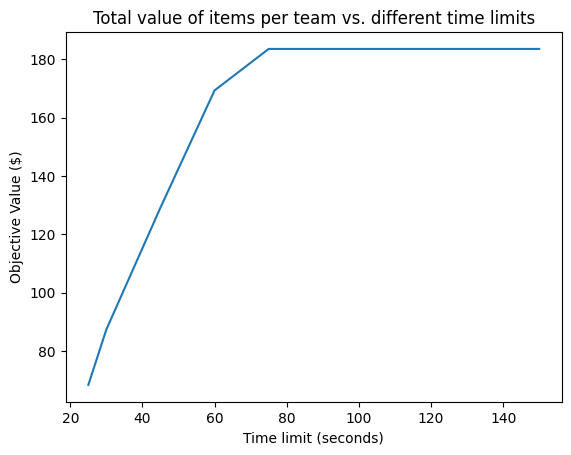

In [27]:
plt.plot(times, obj_vals)
plt.xlabel("Time limit (seconds)")
plt.ylabel("Objective Value ($)")
plt.title("Total value of items per team vs. different time limits")
plt.show()

In [29]:
for t, o in zip(times, obj_vals):
    print(f"For time limit {t} seconds, the total value of the team is ${o}")

For time limit 25 seconds, the total value of the team is $68.44
For time limit 30 seconds, the total value of the team is $87.41999999999999
For time limit 45 seconds, the total value of the team is $129.17
For time limit 60 seconds, the total value of the team is $169.3
For time limit 75 seconds, the total value of the team is $183.50000000000003
For time limit 90 seconds, the total value of the team is $183.50000000000003
For time limit 100 seconds, the total value of the team is $183.50000000000003
For time limit 120 seconds, the total value of the team is $183.50000000000006
For time limit 150 seconds, the total value of the team is $183.50000000000003


## Part e) Sequential Path Optimization
Compute shoppers' paths sequentially
1) Compute path for Shopper 1 to maximize total value of items in their own cart.
2) Compute path for Shopper 2 to maximize total value of items in their own cart, while ensuring that Shopper 2 does not pick items selected by Shopper 1.

In [32]:
def solve_seq_supermarket_sweep(I, v, T, M, d, s, s1_items=None):
    """
    Solves the sequential supermarket sweep problem for the given parameters and returns the optimal value
    """

    # build model
    prob2 = LpProblem("Supermarket_Sweep_Seq", LpMaximize)

    # decision variables
    # x_ij
    x = LpVariable.dicts(
        "x",
        ((i, j) for i in N for j in N),
        lowBound=0,
        upBound=1,
        cat=LpBinary
    )

    # y_j
    y = LpVariable.dicts(
        "y",
        (j for j in N),
        lowBound=0,
        cat="Continuous"
    )

    # t_ij
    t = LpVariable.dicts(
        "t",
        ((i, j) for i in N for j in N),
        lowBound=0,
        cat="Continuous"
    )

    # g_i
    g = LpVariable.dicts(
        "g",
        (i for i in I),
        lowBound=0,
        upBound=1,
        cat=LpBinary
    )

    # objective function
    prob2 += lpSum(g[i] * v[i] for i in I)

    # constraints
    # (17) shopper leaves visited item once
    for i in I:
        prob2 += lpSum(x[i, j] for j in N) == g[i]

    # (18) shopper arrives visited item once
    for j in I:
        prob2 += lpSum(x[i, j] for i in N) == g[j]

    # (19) start and end must be visited
    prob2 += lpSum(x[0, j] for j in N if j != 0) == 1
    prob2 += lpSum(x[i, end_idx] for i in N if i != end_idx) == 1

    # (20) cannot arrive/enter start; cannot leave end
    prob2 += lpSum(x[i, 0] for i in N if i != 0) == 0
    prob2 += lpSum(x[end_idx, j] for j in N if j != end_idx) == 0

    # (21) cannot stay on same node
    for i in N:
        prob2 += x[i, i] == 0

    # (22) link t and x
    for i in N:
        for j in N:
            prob2 += t[i, j] <= M * x[i, j]

    # (23) start time is 0
    prob2 += y[0] == 0

    # (24) y_j in terms of t_ij
    for j in N:
        if j == 0:
            continue
        prob2 += y[j] == lpSum(t[i, j] for i in N if i != end_idx)

    # (25) time to next item
    for j in I:
        prob2 += (
            lpSum(t[j, k] for k in N) == y[j] 
            + 2 * g[j]
            + lpSum(d[j, k] * x[j, k] for k in N)
        )

    # (26) time to next item from start j=0
    prob2 += (
        lpSum(t[0, k] for k in N) == y[0] 
        + lpSum(d[0, k] * x[0, k] for k in N)
    )

    # (27) time limit
    prob2 += y[end_idx] <= T

    # (28) at most 10 items per shopper
    prob2 += lpSum(g[i] for i in I) <= 10

    # (32) shopper 2 cannot grab items picked by shopper 1
    if s == 2:
        assert s1_items is not None
        for i in s1_items:
            prob2 += g[i] == 0


    # solve
    prob2.solve(GUROBI_CMD(path=path_to_Gurobi, msg=1, options=[("MIPFocus", 2)], keepFiles=True))

    print("Solution status:", LpStatus[prob2.status])
    print()

    
    # report
    print(f"Shopper {s}:")
    print()

    # opt objective value
    print("Total value:", value(prob2.objective))
    print()

    # shopper's values
    items = [i for i in I if g[i].varValue > 0.5]
    s1_val = sum(v[i] for i in items)

    # items grabbed
    print("  Items grabbed:")
    for i in items:
        item_name = items_df.loc[i-1, "Item "]
        print(f"    i = {i}: {item_name} (value = ${v[i]:.2f})")

    # items value
    print(f"  Total value for shopper 1: ${s1_val:.2f}")
    print()

    # path
    path = [0]
    current = 0
    while current != end_idx:
        next_nodes = [j for j in N if x[current, j].varValue > 0.5]
        next_node = next_nodes[0]
        path.append(next_node)
        current = next_node

    print("  Path (node indices):", path)

    # arrival times
    print("  Arrival times:")
    for j in path:
        print(f"    Node {j}: y = {y[j].varValue:.2f} sec")

    print()

    return value(prob2.objective), items

#### Shopper 1

In [35]:
s1_value, s1_items = solve_seq_supermarket_sweep(I, v, T, M, d, s=1)

Set parameter Username
Set parameter LicenseID to value 2728574
Set parameter MIPFocus to value 2
Set parameter LogFile to value "gurobi.log"
Using license file /Users/jamiedo/gurobi.lic
Academic license - for non-commercial use only - expires 2026-10-28

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 25.0.0 25A362)
Copyright (c) 2025, Gurobi Optimization, LLC

Read LP format model from file Supermarket_Sweep_Seq-pulp.lp
Reading time = 0.01 seconds
OBJ: 3655 rows, 6842 columns, 23653 nonzeros

Using Gurobi shared library /opt/anaconda3/lib/libgurobi120.dylib

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPFocus  2

Optimize a model with 3655 rows, 6842 columns and 23653 nonzeros
Model fingerprint: 0xe69ead5c
Variable types: 3422 continuous, 3420 integer (3420 binary)
Coefficient statistics:
  Matrix range     [5e-01, 6e+01]
  Objective range  [2e+00, 3e+01]
  Bounds range     [1e+00, 1e+

#### Shopper 2

In [38]:
s2_value, s2_items = solve_seq_supermarket_sweep(I, v, T, M, d, s=2, s1_items=s1_items)

Set parameter Username
Set parameter LicenseID to value 2728574
Set parameter MIPFocus to value 2
Set parameter LogFile to value "gurobi.log"
Using license file /Users/jamiedo/gurobi.lic
Academic license - for non-commercial use only - expires 2026-10-28

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 25.0.0 25A362)
Copyright (c) 2025, Gurobi Optimization, LLC

Read LP format model from file Supermarket_Sweep_Seq-pulp.lp
Reading time = 0.01 seconds
OBJ: 3665 rows, 6842 columns, 23663 nonzeros

Using Gurobi shared library /opt/anaconda3/lib/libgurobi120.dylib

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPFocus  2

Optimize a model with 3665 rows, 6842 columns and 23663 nonzeros
Model fingerprint: 0x8e1f7e3d
Variable types: 3422 continuous, 3420 integer (3420 binary)
Coefficient statistics:
  Matrix range     [5e-01, 6e+01]
  Objective range  [2e+00, 3e+01]
  Bounds range     [1e+00, 1e+

In [40]:
print("Total Value of Items (both shoppers):", s1_value + s2_value)

Total Value of Items (both shoppers): 164.8
